### Import Libraries

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise import Reader, Dataset
import numpy as np

### Loading Dataset

In [149]:
file_path = '../Data/cierra_updated.csv'
data = pd.read_csv(file_path)
data.head(5)

,category,title,price,link,image,description,top,middle,base
0,Women,"Aberchrombie & Fitch, Authentic Away Edp 100Ml...","KSh10,900.00",https://cierraperfumes.com/product/aberchrombi...,https://i0.wp.com/cierraperfumes.com/wp-conten...,"The journey is a trip, but the destination is ...","Top Notes: Brazilian Mandarin, Red Currant, Pear","Heart Notes: Plush Pink Freesia, Muguet and Ja...","Base Notes: Warm Praline, Amber, Musk"
1,Women,"Aberchrombie & Fitch, Authentic Night Edp 100Ml W","KSh7,400.00",https://cierraperfumes.com/product/aberchrombi...,https://i0.wp.com/cierraperfumes.com/wp-conten...,Authentic Night for Women is for the woman who...,Fragrance Notes:,"A mouth-watering combination of Black Currant,...",NaN
2,Women,"Aberchrombie & Fitch, Authentic Night Edp 100M...","KSh9,100.00",https://cierraperfumes.com/product/aberchrombi...,https://i0.wp.com/cierraperfumes.com/wp-conten...,Authentic Night by Abercrombie & Fitch 100ml E...,3 Piece Set Includes:,– 100ml Eau De Parfum Spray– 200ml Perfumed Bo...,Authentic Night for Women is for the woman who...
3,Women,"AFNAN, 9AM EDP 100ML W","KSh6,500.00",https://cierraperfumes.com/product/afnan-9am-e...,https://i0.wp.com/cierraperfumes.com/wp-conten...,Afnan 9am perfume for women is a fruity-spicy ...,"Top Notes: Mandarin, Cedrat, Cardamom and Pink...","Middle Notes: Lavender, Orange Blossom, Rose a...","Base Notes: Cedarwood, Moss, Patchouli and Musk"
4,Women,"AFNAN, VIOLET BOUQUET EDP 100ML W","KSh7,300.00",https://cierraperfumes.com/product/afnan-viole...,https://i0.wp.com/cierraperfumes.com/wp-conten...,Violet Bouquet is an opulent signature scent o...,"Top notes: Sweet, Woody, Saffron, Citrus.","Middle notes: Aromatic, Amber, Orange, Citrus ...","Base notes: Fresh Spicy, Ambergris, Oak Moss, ..."


In [150]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479 entries, 0 to 2478
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     2479 non-null   object
 1   title        2479 non-null   object
 2   price        2478 non-null   object
 3   link         2479 non-null   object
 4   image        2477 non-null   object
 5   description  2340 non-null   object
 6   top          1920 non-null   object
 7   middle       1530 non-null   object
 8   base         1233 non-null   object
dtypes: object(9)
memory usage: 174.4+ KB


In [151]:
data.shape

(2479, 9)

### 1.Data Cleaning 

In [152]:
# Checking for duplicate 
print(f"The DataFrame have {data.duplicated().sum()} duplicate")


The DataFrame have 0 duplicate


In [153]:
##Strip any leading/trailing spaces in text columns
text_columns = ['category', 'title', 'price','description', 'top', 'middle', 'base']
for col in text_columns:
    data[col] = data[col].str.strip()


In [154]:
#Convert Price to numeric after removing any non-numeric characters
# Fill missing values with 0
data['price'] = data['price'].fillna('KSh0')
data['price'] = data['price'].replace({'KSh': '', ',': ''}, regex=True).astype(float).astype(int)

In [155]:
data.isnull().sum()

category          0
title             0
price             0
link              0
image             2
description     139
top             559
middle          949
base           1246
dtype: int64

In [156]:
#Fill null values in categorical columns with a placeholder 'Unknown'
data.fillna('Unknown', inplace=True)

#### 2. EDA

#### What are the gender in the dataset and what is the distribution for each?

In [157]:
data.category.value_counts()

category
Women     1000
Unisex     791
Men        688
Name: count, dtype: int64

In [158]:
# What the percentage of each gender in the dataset?
total = len(data.index)
women = (len(data[data['category'] == 'Women'].index)/total)*100
men = (len(data[data['category'] == 'Men'].index)/total)*100
unisex = (len(data[data['category'] == 'Unisex'].index)/total)*100

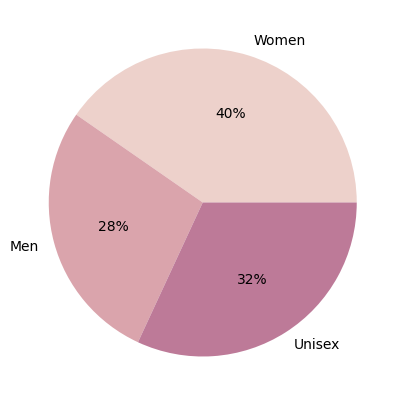

In [159]:
colors = sns.cubehelix_palette()[0:5]
fig = plt.figure(figsize = (10, 5))
data = [women, men, unisex, ]
labels = ['Women', 'Men', 'Unisex',]

fig.patch.set_facecolor('white')
#create pie chart
plt.pie(data, labels= labels , colors = colors, autopct='%.0f%%')
plt.show()

#### 2. MODELING

In [161]:
# Remove any leading or trailing whitespace from each note
data['top_notes'] = data['top'].apply(lambda x: [note.strip() for note in x] if isinstance(x, list) else [])
data['middle_notes'] = data['middle'].apply(lambda x: [note.strip() for note in x] if isinstance(x, list) else [])
data['base_notes'] = data['base_notes'].apply(lambda x: [note.strip() for note in x] if isinstance(x, list) else [])

TypeError: list indices must be integers or slices, not str

In [163]:
# Split the 'top', 'middle', and 'base' columns by commas
data['top_notes'] = data['top'].str.split(',')
data['middle_notes'] = data['middle'].str.split(',')
data['base_notes'] = data['base'].str.split(',')

TypeError: list indices must be integers or slices, not str

In [ ]:
# Combine top, middle, and base notes into a single string for each perfume  
data['All Notes'] = data['top'] + " " + data['middle'].fillna('') + " " + data['base']



# Vectorize the notes  
tfidf = TfidfVectorizer()  
tfidf_matrix = tfidf.fit_transform(df['All Notes']) 

TypeError: list indices must be integers or slices, not str

In [ ]:
# Calculate cosine similarity  
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)  

# Function to recommend perfumes  
def recommend_perfume(title, num_recommendations=5):  
    idx = df.index[df['Title'] == title].tolist()[0]  
    sim_scores = list(enumerate(cosine_sim[idx]))  
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)  
    top_items = sim_scores[1:num_recommendations + 1]  
    perfume_indices = [i[0] for i in top_items]  
    return df.iloc[perfume_indices][['Title', 'Price', 'Link', 'Image', 'Description']]  


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# extracting fragrance notes
data['notes'] = data['top'].apply(lambda x: extract_notes(x))  # Define extract_notes function

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['notes'])

TypeError: list indices must be integers or slices, not str

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

# Compute cosine similarity based on the TF-IDF matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Create a DataFrame to hold the similarity scores
indices = pd.Series(data.index, index=data['categorytitle']).drop_duplicates()

NameError: name 'tfidf_matrix' is not defined

In [ ]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the perfume that matches the title
    idx = indices[title]

    # Get the pairwise similarity scores of all perfumes with that perfume
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the perfumes based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar perfumes
    sim_scores = sim_scores[1:11]  # Exclude the first one, which is the perfume itself

    # Get the perfume indices
    perfume_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar perfumes
    return data.iloc[perfume_indices]

# Example usage
recommendations = get_recommendations('Aberchrombie & Fitch, Authentic Away Edp 100Ml W Gift Set')
print(recommendations[['categorytitle', 'price', 'link']])

NameError: name 'cosine_sim' is not defined